<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/LSTM_4_FINISHiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas, math, numpy
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, GRU 

from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, LSTM, GRU

from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from datetime import datetime # for put the time info in each plot          #https://stackoverflow.com/questions/415511/how-to-get-the-current-time-in-python

In [11]:
!gdown --id 1KzPoPcXQghi2dxSc4ZPhO5Rz9QB0PWHv            #normalized data

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KzPoPcXQghi2dxSc4ZPhO5Rz9QB0PWHv
To: /content/color_norm.csv
100% 190M/190M [00:02<00:00, 94.6MB/s]


In [ ]:
!pip install --upgrade --no-cache-dir gdown #If they do not allow donwload

In [ ]:
#df = pd.read_csv("C:/Users/luano/Documents/LSTM/LSTM 3/color_norm.csv")  #FOR WINDOWS
#!gdown --id 1V_S8hoqK9g5mCMxwRGZbsyhuK7KjxZHl            #FOR GOOGLECOLAB
!gdown --id 1KzPoPcXQghi2dxSc4ZPhO5Rz9QB0PWHv            #normalized data
df = pd.read_csv("color_norm.csv")
# dfn['beta'] = dfn['beta'].str.split(',').map(lambda x: list(map(float, x)))
df['Series']    = df['Series'].str.split(',').map(   lambda x: list(map(float, x)))
df['PSD']       = df['PSD'].str.split(',').map(      lambda x: list(map(float, x)))
df['Frequency'] = df['Frequency'].str.split(',').map(lambda x: list(map(float, x)))


In [141]:


serie_index = 80

min_size , max_size = 0 , 30000

dataframe = pd.DataFrame({"Serie":df['Series'][serie_index][min_size:max_size]})
dataset = dataframe.values
dataset = dataset.astype('float32')

beta = str(df['beta'][serie_index])

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KzPoPcXQghi2dxSc4ZPhO5Rz9QB0PWHv
To: /content/color_norm.csv
100% 190M/190M [00:03<00:00, 49.0MB/s]


In [142]:
# definindo as amostras de treinamento e teste segundo o hold-out.
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# conversão da série temporal em uma matriz de atributos para regressão
def create_dataset(dataset, look_back=10):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# Atributos X=t and Y=t+1
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [144]:
#Setting Random seeds🌱
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(3)

# create and fit the LSTM network
modelo = GRU

model = Sequential()
model.add(modelo(10, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam',metrics=[metrics.MeanSquaredError(),metrics.AUC(),])

history = model.fit(trainX, trainY, epochs=100, batch_size=len(trainX), verbose=0,validation_split=0.8)

In [145]:
##Alocating the results
loss =     history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(0,len(loss))

#Defing a general file name
filename_traingXloss ="TraingLoss_beta"+str(df['beta'][serie_index])+"_timeSerieSize="+str(max_size-min_size)+"_nsteps="+str(look_back)+"_eposch="+str(len(epochs))

#Saving a DataFrame with the Results
df_results = pd.DataFrame({'loss': loss, 'val_los': val_loss,'epochs':epochs})         
df_results.to_csv((filename_traingXloss+".csv"), index=False)



In [146]:
min(loss)

0.000244815630139783

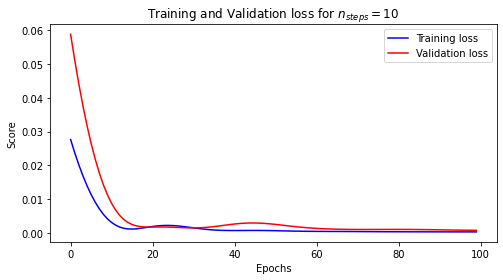

In [147]:
#Plot the Training and Validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs,loss,    label='Training loss',  color='blue')
plt.plot(epochs,val_loss,label='Validation loss',color='red')
plt.xlabel('Epochs')
plt.ylabel('Score')
# Ploting the max value of vall_loss. We dont need these all the time, only whem test limits of the network
#plt.scatter(history.history['val_loss'].index(max(history.history['val_loss'])),max(history.history['val_loss']),label=('Max Val Loss ='+str(round(max(history.history['val_loss']),2))+"\nEpoch = "+str(history.history['val_loss'].index(max(history.history['val_loss'])))),color='purple',zorder=3,marker='*',linewidths=2)
plt.legend()
plt.title("Training and Validation loss for $n_{steps} =$"+str(look_back))
#time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')).replace(":","_") # What time is that? 
#plt.savefig(time+filename_traingXloss+".pdf")                             #Saving the figure with the currently data and time
plt.show()

In [148]:
# make predictions
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
# trainY1      =([trainY])
# testY1       =([testY])

# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY1[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY1[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
model_data =  numpy.empty_like(dataset) #creating a empyt vector
model_data[look_back:len(trainPredict)+look_back, :] = trainPredict #alocating the the traint data generatead by the model
model_data[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict #alocating the the test data generatead by the model
model_data = (np.reshape(model_data,(len(model_data))))
model_data[:look_back] = numpy.nan
#model_data = model_data[look_back:]

# Killing divergences
for i in range(len(model_data)):
    if model_data[i] > 1: model_data[i] = numpy.nan
    #if model_data[i] < 0.0001: model_data[i] = 0


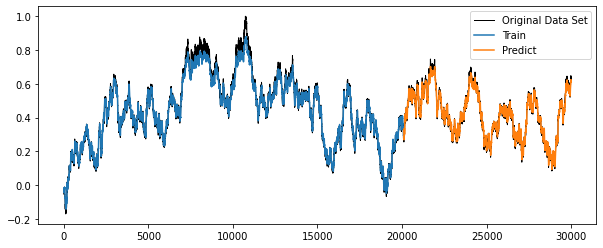

In [149]:
plt.figure(figsize = (10,4))
plt.plot(dataset,label="Original Data Set",color = 'black',linewidth=1)
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Predict')
#plt.plot(model_data,linestyle='--',linewidth=0.4)
#plt.plot(x,df['Series'][serie_index][max_size:max_size+len(x)])
plt.legend()
plt.savefig(time+'Results_beta_'+beta+'model_'+modelos+'lookback_'+str(look_back)+'npoins_'+str(max_size+min_size)+".pdf")
plt.show()

In [150]:
#Alocating these results in a dataframe
df_time =  pd.DataFrame(dataset[:2**int(np.log2(len(dataset)))])
df_model = pd.DataFrame(model_data[:2**int(np.log2(len(model_data)))])

#Creating and save has a CSV
df_time.to_csv("time.csv", index=False, header=False)
df_model.to_csv("model.csv", index=False, header=False)

#Generate 
time_series = list(np.reshape(dataset,(1,len(dataset)))[0])
data_model = list(model_data)
df_final = pd.DataFrame({"time_series":time_series,"model_data":data_model})

modelos = 'LSTM' if str(modelo)[-6:-2] else 'GRU'
time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')).replace(":","_")    

df_final.to_csv(time+'beta_'+beta+'model_'+modelos+'lookback_'+str(look_back)+'npoins_'+str(max_size+min_size)+".csv")

In [151]:
#csv_para_txt
import csv
with open("serie_time.txt", "w") as my_output_file: 
    with open("time.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

with open("model_data.txt", "w") as my_output_file: 
    with open("model.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()
#

In [152]:
############################################################################
# #The following lines its a code provid by Reinaldo Rosa called SpecPlus.
# #the original code is on google colab. Here, is just a resume
############################################################################
def specplus(nomeArquivo):
    cor = 'black' if nomeArquivo == 'serie_time.txt' else 'C0'

    titulo =  'Original Time Series Data' if nomeArquivo == 'serie_time.txt'  else 'Model Time Series Data'


    import matplotlib.pyplot as plt
    import matplotlib.mlab as mlab
    from scipy import stats, optimize
    import numpy as np
    import math
    __authors__ = 'Paulo Giovani & Reinaldo Rosa'
    __copyright__ = 'Copyright 2017, 3DBMO Project INPE'
    __credits__ = ['Paulo Giovani', 'Reinaldo Roberto Rosa', 'Murilo da Silva Dantas']
    __license__ = 'GPL'
    __version__ = '0.1B'
    __maintainer__ = 'Paulo Giovani'
    __email__ = 'pg_faria@yahoo.com.br'
    time = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S')).replace(":","_")    
    #---------------------------------------------------------------------
    # Calcula o PSD da série temporal
    #---------------------------------------------------------------------
    def psd(data):
        """Calcula o PSD de uma série temporal."""
        # Define um intervalo para realizar o ajuste da reta
        INICIO = 10
        FIM = 2000
        # O vetor com o tempo é o tamanho do número de pontos
        N = len(data)
        tempo = np.arange(len(data))
        # Define a frequência de amostragem
        dt = (tempo[-1] - tempo[0] / (N - 1))
        fs = 1 / dt
        # Calcula o PSD utilizando o MLAB
        power, freqs = mlab.psd(data, Fs = fs, NFFT = N, scale_by_freq = False)
        # Calcula a porcentagem de pontos utilizados na reta de ajuste
        totalFrequencias = len(freqs)
        totalPSD = FIM - INICIO
        porcentagemPSD = int(100 * totalPSD / totalFrequencias)
        # Seleciona os dados dentro do intervalo de seleção
        xdata = freqs[INICIO:FIM]
        ydata = power[INICIO:FIM]
        # Simula o erro
        yerr = 0.2 * ydata
        # Define uma função para calcular a Lei de Potência
        powerlaw = lambda x, amp, index: amp * (x**index)
        # Converte os dados para o formato LOG
        logx = np.log10(xdata)
        logy = np.log10(ydata)
        # Define a função para realizar o ajuste
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err    
        logyerr = yerr / ydata
        # Calcula a reta de ajuste
        pinit = [1.0, -1.0]
        out = optimize.leastsq(errfunc, pinit, args = (logx, logy, logyerr), full_output = 1)    
        pfinal = out[0]
        covar = out[1]
        index = pfinal[1]
        amp = 10.0 ** pfinal[0]
        indexErr = np.sqrt(covar[0][0])
        ampErr = np.sqrt(covar[1][1]) * amp
        # Retorna os valores obtidos
        return freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM

    #---------------------------------------------------------------------
    # Calcula o DFA 1D da série temporal
    #---------------------------------------------------------------------

    def dfa1d(timeSeries, grau):
        """Calcula o DFA 1D (adaptado de Physionet), onde a escala cresce
        de acordo com a variável 'Boxratio'. Retorna o array 'vetoutput', 
        onde a primeira coluna é o log da escala S e a segunda coluna é o
        log da função de flutuação."""
        # 1. A série temporal {Xk} com k = 1, ..., N é integrada na chamada função perfil Y(k)
        x = np.mean(timeSeries)
        timeSeries = timeSeries - x
        yk = np.cumsum(timeSeries)
        tam = len(timeSeries)
        # 2. A série (ou perfil) Y(k) é dividida em N intervalos não sobrepostos de tamanho S
        sf = np.ceil(tam / 4).astype(np.int)
        boxratio = np.power(2.0, 1.0 / 8.0)
        vetoutput = np.zeros(shape = (1,2))
        s = 4
        while s <= sf:        
            serie = yk        
            if np.mod(tam, s) != 0:
                l = s * int(np.trunc(tam/s))
                serie = yk[0:l]			
            t = np.arange(s, len(serie), s)
            v = np.array(np.array_split(serie, t))
            l = len(v)
            x = np.arange(1, s + 1)
            # 3. Calcula-se a variância para cada segmento v = 1,…, n_s:
            p = np.polynomial.polynomial.polyfit(x, v.T, grau)
            yfit = np.polynomial.polynomial.polyval(x, p)
            vetvar = np.var(v - yfit)
    # 4. Calcula-se a função de flutuação DFA como a média das variâncias de cada intervalo
            fs = np.sqrt(np.mean(vetvar))
            vetoutput = np.vstack((vetoutput,[s, fs]))
            # A escala S cresce numa série geométrica
            s = np.ceil(s * boxratio).astype(np.int)
        # Array com o log da escala S e o log da função de flutuação   
        vetoutput = np.log10(vetoutput[1::1,:])
        # Separa as colunas do vetor 'vetoutput'
        x = vetoutput[:,0]
        y = vetoutput[:,1]
        # Regressão linear
        slope, intercept, _, _, _ = stats.linregress(x, y)
        # Calcula a reta de inclinação
        predict_y = intercept + slope * x
        # Calcula o erro
        pred_error = y - predict_y
        # Retorna o valor do ALFA, o vetor 'vetoutput', os vetores X e Y,
        # o vetor com os valores da reta de inclinação e o vetor de erros
        return slope, vetoutput, x, y, predict_y, pred_error
    #---------------------------------------------------------------------
    # Trecho principal
    #---------------------------------------------------------------------
    def main():
        """Função com o código principal do programa."""
        #print("\nSpectral Analysis for time series...\n")
        # Desabilita as mensagens de erro do Numpy (warnings)
        old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')
        # Carrega o arquivo de dados
        #nomeArquivo = 'serie1.txt'		
        data = np.genfromtxt(nomeArquivo,
                             delimiter = ',',
                             dtype = 'float32',
                             filling_values = 0)
        # Exibe os primeiro N valores do arquivo
        N = 10
        #print("Original time series data (%d points): \n" %(len(data)))
        #print("First %d points: %s\n" %(N, data[0:10]))
        #print()
        #-----------------------------------------------------------------
        # Parâmetros gerais de plotagem
        #-----------------------------------------------------------------
        # Define os subplots
        fig = plt.figure()
        fig.subplots_adjust(hspace = .4, wspace = .2)
        # Tamanho das fontes
        tamanhoFonteEixoX     = 16
        tamanhoFonteEixoY     = 20
        tamanhoFonteTitulo    = 16
        tamanhoFontePrincipal = 25
        # Título principal
        tituloPrincipal = 'Time Series Spectral Analysis' 	
        #-----------------------------------------------------------------
        # Plotagem da série original
        #-----------------------------------------------------------------
        # Define as cores da plotagem
        corSerieOriginal = cor# 'r'
        # Título dos eixos da série original
        textoEixoX = 'Time'
        textoEixoY = 'Amplitude'
        textoTituloOriginal = titulo
        print("1. Plotting time series data...")
        # Plotagem da série de dados    
        #O = fig.add_subplot(1, 3, 1)    
        O = fig.add_subplot(2, 1, 1)
        O.plot(data, '-', color = corSerieOriginal)
        O.set_title(textoTituloOriginal, fontsize = tamanhoFonteTitulo)
        O.set_xlabel(textoEixoX, fontsize = tamanhoFonteEixoX)
        O.set_ylabel(textoEixoY, fontsize = tamanhoFonteEixoY)
        O.ticklabel_format(style = 'sci', axis = 'x', scilimits = (0,0))
        O.grid()
        #-----------------------------------------------------------------
        # Cálculo e plotagem do PSD                                     --
        #-----------------------------------------------------------------
        # Calcula o PSD
        freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data)
        # O valor do beta equivale ao index
        b = index
        # Define as cores da plotagem
        corPSD1 = 'k'
        corPSD2 = 'navy'
        # Título dos eixos do PSD
        textoPSDX = 'Frequency (Hz)'
        textoPSDY = 'PSD'
        textoTituloPSD = r'Power Spectrum Density $\beta$ = '
        print("2. Plotting Power Spectrum Density...")
        # Plotagem do PSD    
        PSD = fig.add_subplot(2, 2, (3,4))    
        PSD.plot(freqs, power, '-', color = corPSD1, alpha = 0.7)
        PSD.plot(xdata, ydata, color = corPSD2, alpha = 0.8)
        PSD.axvline(freqs[INICIO], color = corPSD2, linestyle = '--')
        PSD.axvline(freqs[FIM], color = corPSD2, linestyle = '--')    
        PSD.plot(xdata, powerlaw(xdata, amp, index), 'r-', linewidth = 1.5, label = '$%.4f$' %(b))    
        PSD.set_xlabel(textoPSDX, fontsize = tamanhoFonteEixoX)
        PSD.set_ylabel(textoPSDY, fontsize = tamanhoFonteEixoY)
        PSD.set_title(textoTituloPSD + '%.4f' %(b), loc = 'center', fontsize = tamanhoFonteTitulo)
        PSD.set_yscale('log')
        PSD.set_xscale('log')
        PSD.grid() 
        #-----------------------------------------------------------------
        # Cálculo e plotagem do DFA
        #-----------------------------------------------------------------
        # Calcula o DFA 1D
        alfa, vetoutput, x, y, reta, erro = dfa1d(data, 1)
        # Verifica se o DFA possui um valor válido
        # Em caso afirmativo, faz a plotagem
        # if not math.isnan(alfa):
        # 	# Define as cores da plotagem
        # 	corDFA = 'darkmagenta'
        # 	# Título dos eixos do DFA
        # 	textoDFAX = '$log_{10}$ (s)'
        # 	textoDFAY = '$log_{10}$ F(s)'
        # 	textoTituloDFA = r'Detrended Fluctuation Analysis $\alpha$ = '
        # 	print("3. Plotting Detrended Fluctuation Analysis...")
        # 	# Plotagem do DFA 
        # 	DFA = fig.add_subplot(2, 2, 4)    
        # 	DFA.plot(x, y, 's', 
        # 			 color = corDFA, 
        # 			 markersize = 4
        # 			 markeredgecolor = 'r',
        # 			 markerfacecolor = 'None',
        # 			 alpha = 0.8)				 
        # 	DFA.plot(x, reta, '-', color = corDFA, linewidth = 1.5)
        # 	DFA.set_title(textoTituloDFA + '%.4f' %(alfa), loc = 'center', fontsize = tamanhoFonteTitulo)
        # 	DFA.set_xlabel(textoDFAX, fontsize = tamanhoFonteEixoX)
        # 	DFA.set_ylabel(textoDFAY, fontsize = tamanhoFonteEixoY)
        # 	DFA.grid()
        # else:  
        # 	DFA = fig.add_subplot(2, 2, 4)
        # 	DFA.set_title(textoTituloDFA + 'N.A.', loc = 'center', fontsize = tamanhoFonteTitulo)
        # 	DFA.grid()
        #-----------------------------------------------------------------
        # Exibe e salva a figura
        #-----------------------------------------------------------------
        #plt.suptitle(tituloPrincipal, fontsize = tamanhoFontePrincipal)
        nomeImagem = time+nomeArquivo+'ANALYSIS_PSD_DFA_.pdf'
        fig.set_size_inches(15, 9)
        plt.savefig(nomeImagem, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)	
        plt.show()
    #---------------------------------------------------------------------
    # Trecho principal
    #---------------------------------------------------------------------
    if __name__ == "__main__":
        main()
    #——————————————————————————————————————————

1. Plotting time series data...
2. Plotting Power Spectrum Density...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

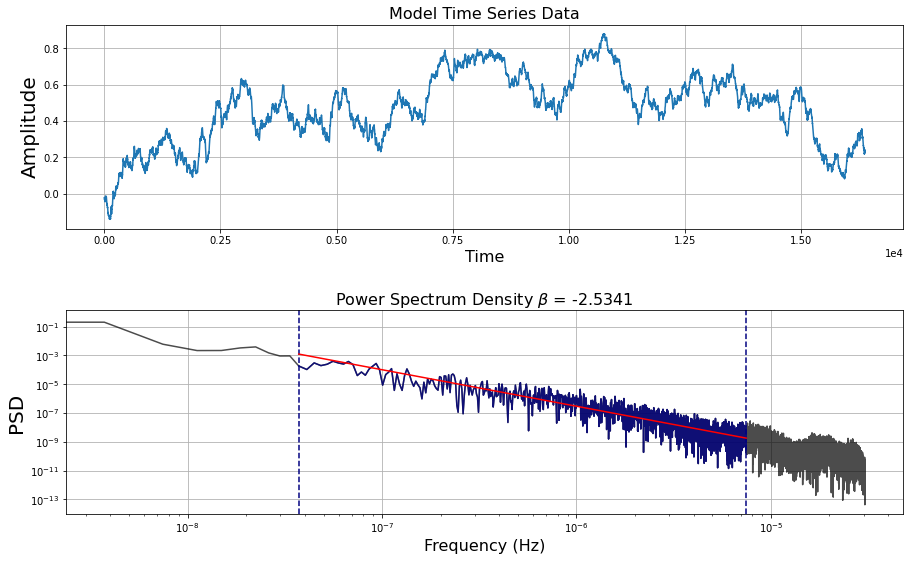

None
1. Plotting time series data...
2. Plotting Power Spectrum Density...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

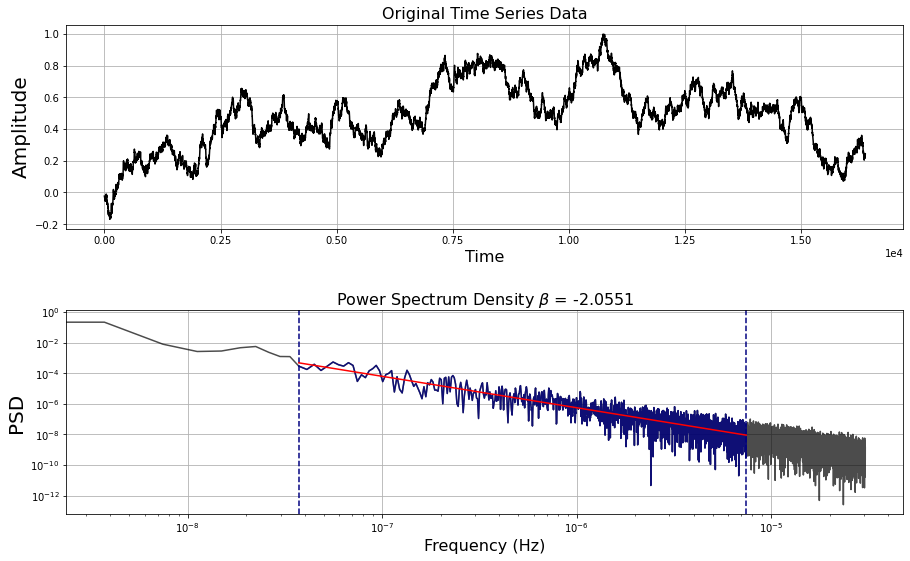

None


In [153]:
print(specplus('model_data.txt'))
print(specplus('serie_time.txt'))